# Other Samplers

Trey V. Wenger (c) August 2024

Here we demonstrate the use of non-standard samplers with `bayes_spec`.

In [1]:
# General imports    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.4.3+8.g2908c9c.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Text(0, 0.5, 'Brightness Temperature (K)')

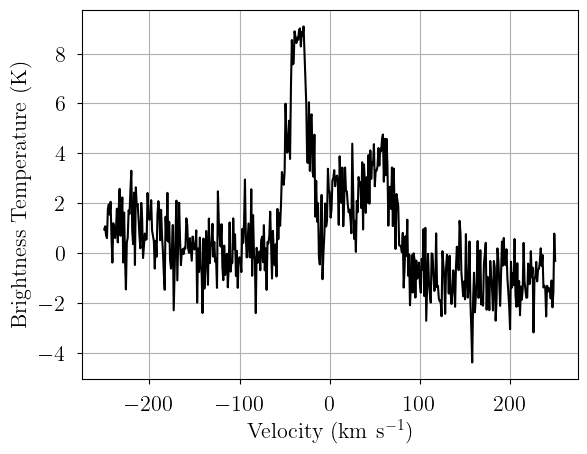

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "observation_baseline_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## MCMC

First, let's revisit the NUTS sampler used in the other notebooks.

In [5]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

Let's use a lot of chains and the `pymc` `"auto"` initialization.

In [6]:
model.sample(
    init = "auto",
    tune = 1000,
    draws = 1000,
    chains = 8,
    cores = 8,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.


Only 7 chains appear converged.
There were 1 divergences in converged chains.


In [7]:
model.solve(p_threshold=0.9)

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [2 1 0]
Chain 1 order: [1 2 0]
Chain 2 order: [1 2 0]
Chain 3 order: [1 0 2]
Chain 4 order: [2 1 0]
Chain 6 order: [2 0 1]
Chain 7 order: [2 1 0]
Adopting (first) most common order: [2 1 0]


Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

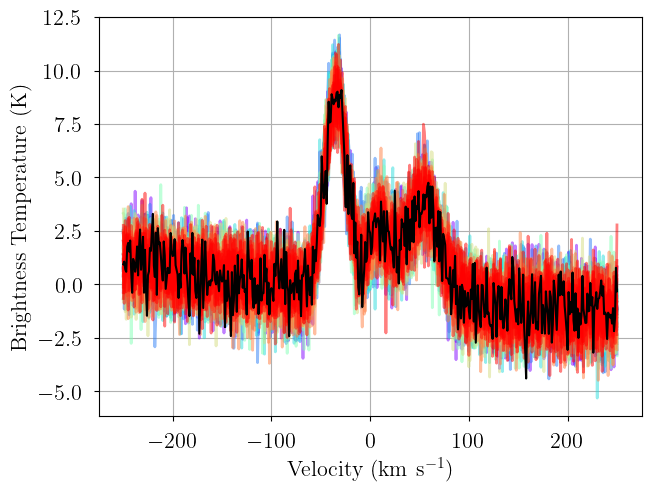

In [8]:
from bayes_spec.plots import plot_predictive

posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

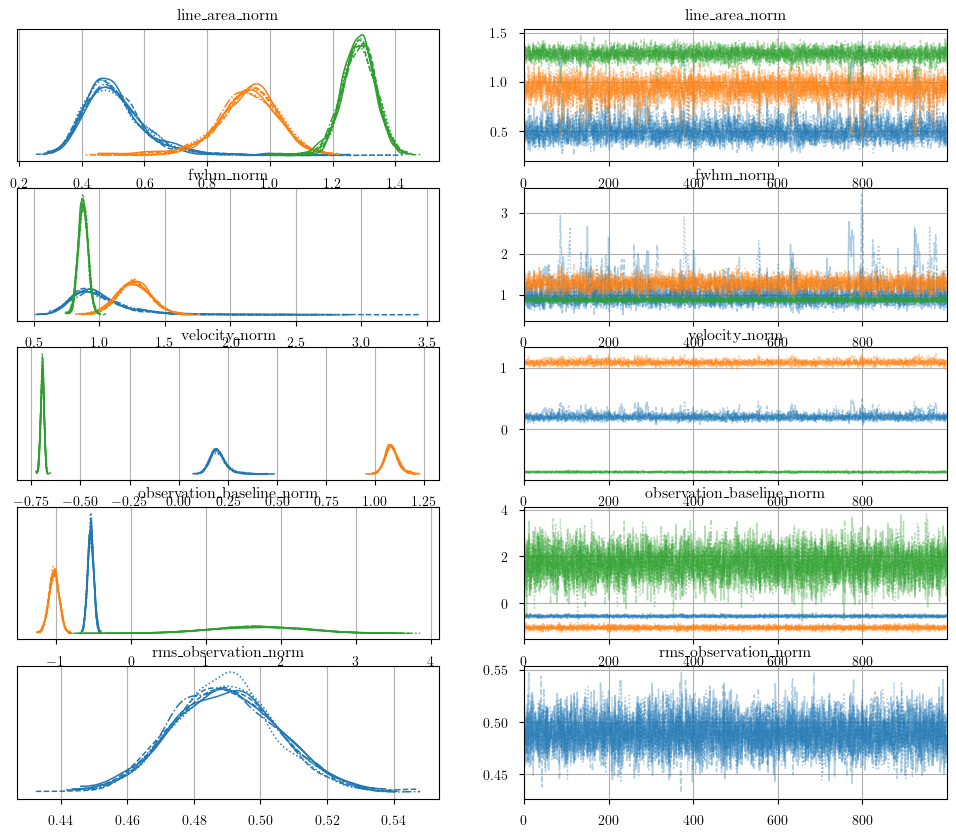

In [9]:
from bayes_spec.plots import plot_traces

plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

In [10]:
pm.summary(model.trace.solution_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],3.189,0.294,2.649,3.758,0.004,0.003,5183.0,4943.0,1.0
amplitude[1],4.602,0.279,4.111,5.110,0.005,0.004,3912.0,2332.0,1.0
amplitude[2],9.186,0.291,8.644,9.719,0.003,0.002,7708.0,4118.0,1.0
fwhm[0],30.240,7.633,19.643,43.261,0.208,0.156,2013.0,1437.0,1.0
fwhm[1],37.941,3.869,30.655,45.390,0.079,0.056,2368.0,2178.0,1.0
fwhm[2],26.244,1.103,24.199,28.324,0.017,0.012,4100.0,3649.0,1.0
fwhm_norm[0],1.008,0.254,0.655,1.442,0.007,0.005,2013.0,1437.0,1.0
fwhm_norm[1],1.265,0.129,1.022,1.513,0.003,0.002,2368.0,2178.0,1.0
fwhm_norm[2],0.875,0.037,0.807,0.944,0.001,0.000,4100.0,3649.0,1.0
line_area[0],101.627,21.917,67.780,140.686,0.578,0.438,2044.0,1500.0,1.0


Here's what I wanted to say:

```
The solution looks *ok*, but inspecting the trace plots and the `r_hat` statistic reveals that the model hasn't converged very well! This is a complicated, multi-modal posterior, and without the help of variational inference getting NUTS to a good starting point, we just have a hard time sampling from this posterior.
```

In reality, however, NUTS has no problem with this model, even with the default initialization! That might not always be the case, so let's play with the other samplers anyway.

## Sequential Monte Carlo

[Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html) is a sampling strategy that overcomes the issues of multi-modal posterior distributions. In this case, where our model is a simple mixture of Gaussians, our posterior is highly multi-modal: chains could "collapse" to a single mode, and there is also the labeling degeneracy. We did not encounter any problems with the default MCMC sampling methods described in the other notebooks, primarily because we *initialized* the sampler using strong constraints from the variational inference initialization.

SMC has two hyperparameters: `draws`, the number of posterior draws (per stage), and `threshold`, which controls the tempering process between stages. Increasing these parameters will help with sampling from complicated models.

In [11]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

In [12]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

Only 7 chains appear converged.


In [13]:
model.solve(p_threshold=0.9)

GMM found 4 unique solutions
Solution 0: chains [0]
Solution 1: chains [1, 3, 4, 5]
Solution 2: chains [6]
Solution 3: chains [7]
Label order mismatch in solution 1
Chain 1 order: [0 2 1]
Chain 3 order: [2 1 0]
Chain 4 order: [0 1 2]
Chain 5 order: [0 2 1]
Adopting (first) most common order: [0 2 1]


Something doesn't look right! Let's investigate by looking at the posterior predictive samples and the trace.

Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

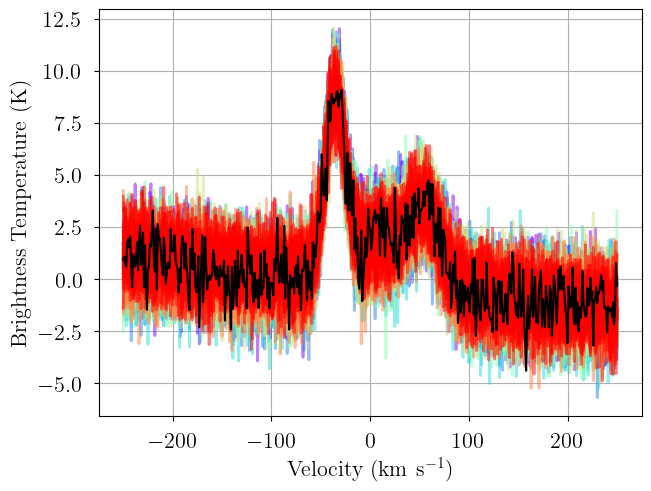

In [14]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

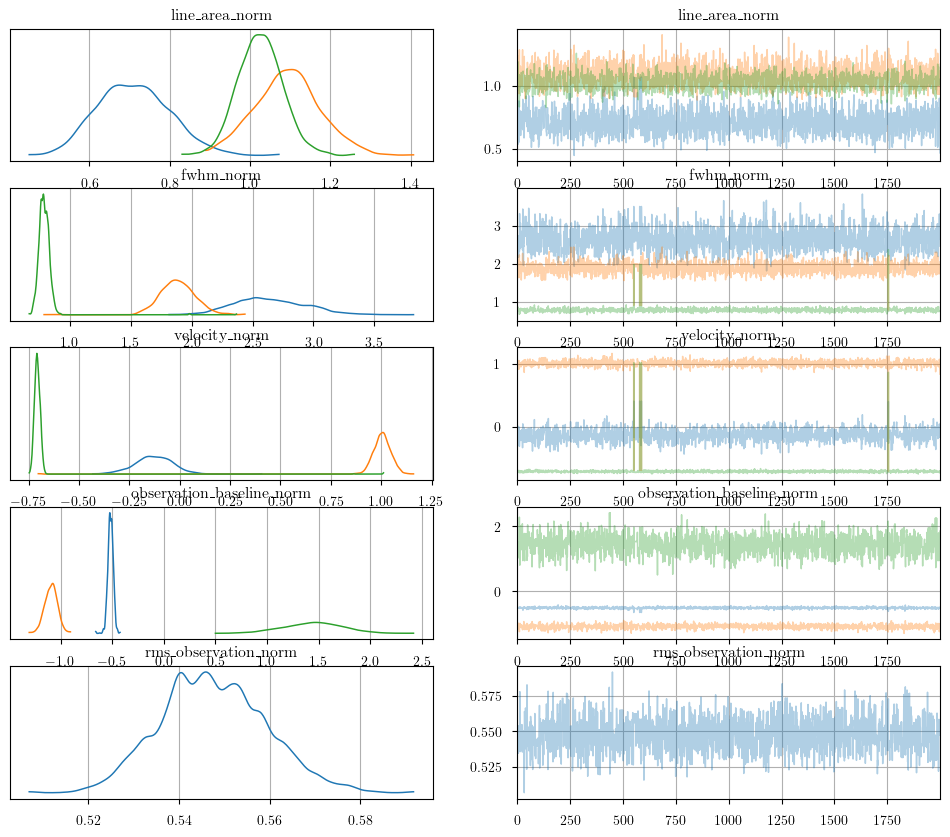

In [15]:
plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

The model has clearly not converged. The issue is actually quite subtle: due to the labeling degeneracy (i.e., the order of the clouds doesn't matter for this model), a single chain may re-order the clouds while sampling, thus causing the assumptions of SMC to break down. For this model, we can overcome this problem by *enforcing* an order on the clouds. The model `GaussNoiseModel` has an option to do just this: `add_priors(ordered=True)`. Note that this changes the definition of the prior distribution on `velocity`. The clouds are *ordered* by increasing velocity, thus breaking the labeling degeneracy. Note that this only works here because our model does not intrinsically depend on the order of the clouds. This is generally true for optically thin emission, but not necessarily true if there is optically thick emission (i.e., self-absorption).

In [16]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [-100.0, 20.0], # lower limit and mode of k=2 gamma distribution on velocity OFFSET between clouds (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
    ordered = True, # enforce ordered velocities
)
model.add_likelihood()

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, rms_observation_norm, velocity_norm]


array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

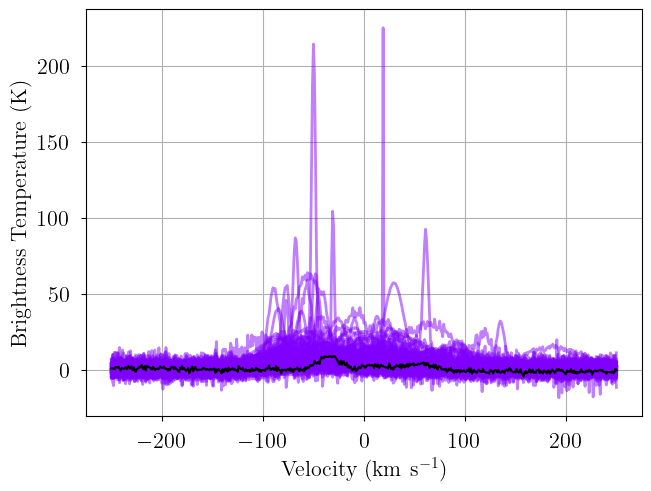

In [17]:
# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
plot_predictive(model.data, prior.prior_predictive)

In [18]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

In [19]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

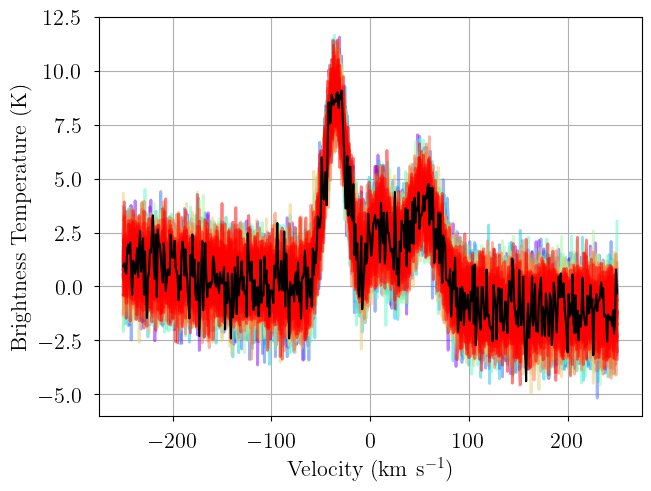

In [20]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

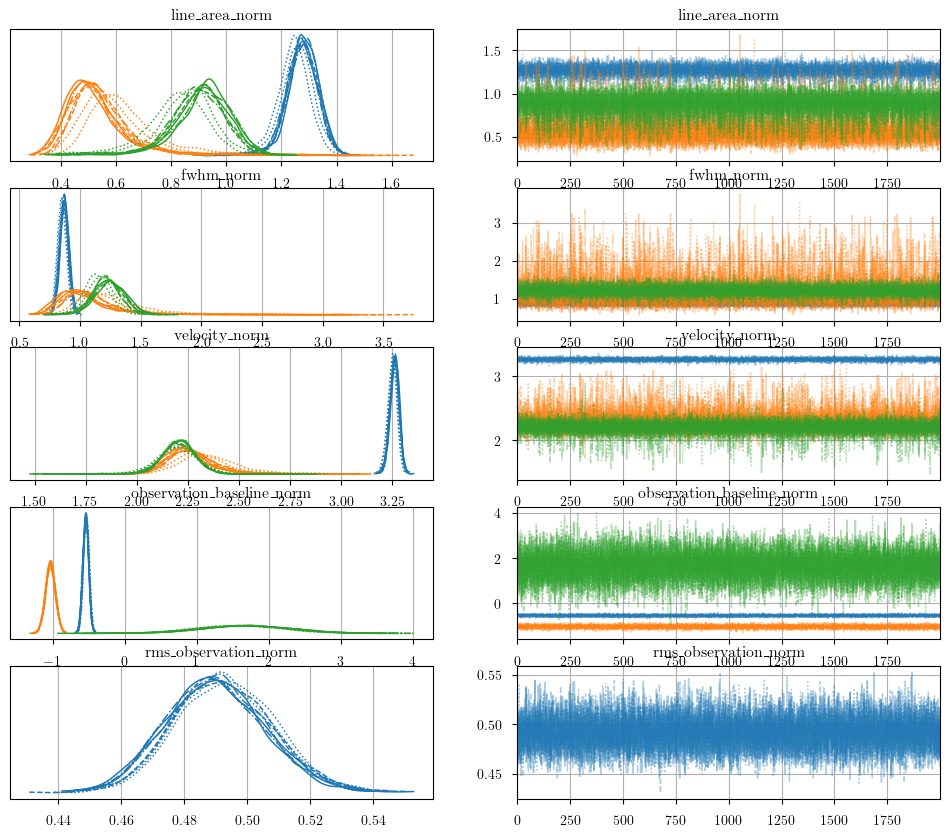

In [21]:
plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

In [22]:
pm.summary(model.trace.solution_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],9.183,0.303,8.624,9.755,0.002,0.002,15710.0,14965.0,1.00
amplitude[1],3.103,0.281,2.573,3.624,0.022,0.015,167.0,1230.0,1.03
amplitude[2],4.577,0.346,3.983,5.175,0.003,0.002,13259.0,14647.0,1.01
fwhm[0],25.950,1.133,23.895,28.165,0.073,0.052,237.0,14462.0,1.02
fwhm[1],34.333,9.859,20.262,50.962,1.046,0.742,53.0,332.0,1.09
fwhm[2],36.276,3.797,29.262,43.538,0.402,0.286,88.0,853.0,1.06
fwhm_norm[0],0.865,0.038,0.797,0.939,0.002,0.002,237.0,14462.0,1.02
fwhm_norm[1],1.144,0.329,0.675,1.699,0.035,0.025,53.0,332.0,1.09
fwhm_norm[2],1.209,0.127,0.975,1.451,0.013,0.010,88.0,853.0,1.06
line_area[0],253.590,12.149,232.311,276.592,0.762,0.542,240.0,14354.0,1.03


## `nutpie`

`nutpie` is a NUTS sampler written in RUST that runs on the CPU. It's much faster than the default `pymc` implementation, but there is less control over its initialization (i.e., we can't initialize it using variational inference). Thus we only consider the `GaussNoiseModel` model with `ordered=True`.

In [23]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "nutpie",
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,10000,0,0.52,15
,10000,0,0.51,15
,10000,0,0.52,15
,10000,0,0.49,15
,10000,0,0.55,15
,10000,0,0.49,31


After a brief delay while the model is compiled, the sampling begins. Note the speed!

In [24]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

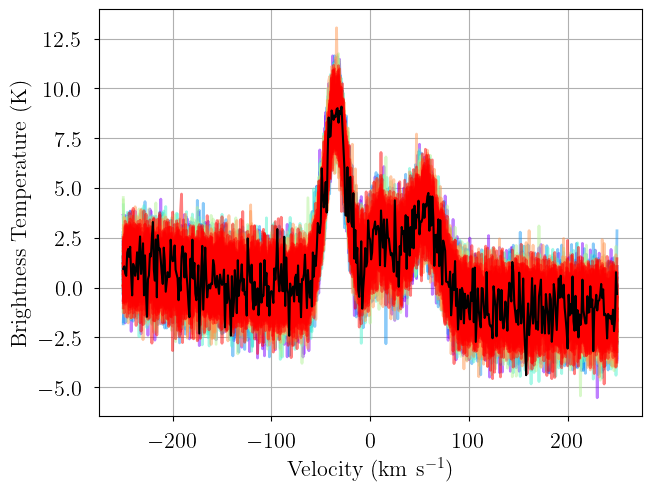

In [25]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

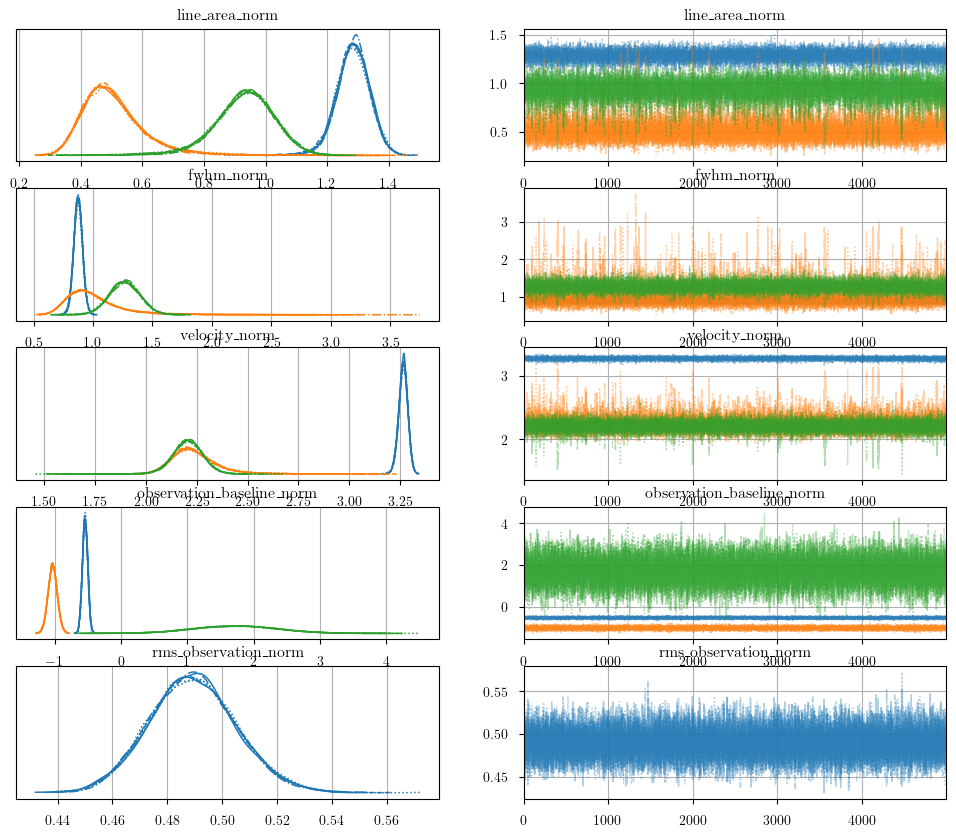

In [26]:
plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

In [27]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
line_area[0],256.581,10.917,236.754,277.137,0.107,0.075,11964.0,9287.0,1.0
line_area[1],101.927,22.615,67.101,141.192,0.313,0.242,7759.0,5338.0,1.0
line_area[2],185.716,20.626,147.868,222.704,0.271,0.191,7330.0,5089.0,1.0
fwhm[0],26.240,1.101,24.205,28.340,0.009,0.006,15466.0,15336.0,1.0
fwhm[1],30.333,7.929,19.060,43.647,0.113,0.087,7791.0,5407.0,1.0
fwhm[2],37.935,3.872,30.681,45.212,0.044,0.031,7997.0,7068.0,1.0
velocity[0],-34.688,0.440,-35.542,-33.875,0.003,0.002,19093.0,14406.0,1.0
velocity[1],10.128,2.307,6.222,14.289,0.030,0.023,8876.0,6289.0,1.0
velocity[2],54.195,1.713,51.107,57.578,0.019,0.014,9120.0,7382.0,1.0
amplitude[0],9.190,0.287,8.666,9.739,0.002,0.001,27111.0,18129.0,1.0


## `numpyro`

`numpyro` is a JAX-based NUTS sampler, and it can run on the GPU. `bayes_spec` provides installation options to suport CUDA GPUs (i.e., nvidia). GPUs aren't usually the way to go, unless you have a lot of them! Otherwise, you'll have to run each chain sequentially. Let's stick to the CPU.

In [28]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform('cpu')
numpyro.set_host_device_count(6)

In [29]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "numpyro",
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Only 4 chains appear converged.


In [30]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]
INFO:pymc.sampling.forward:Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

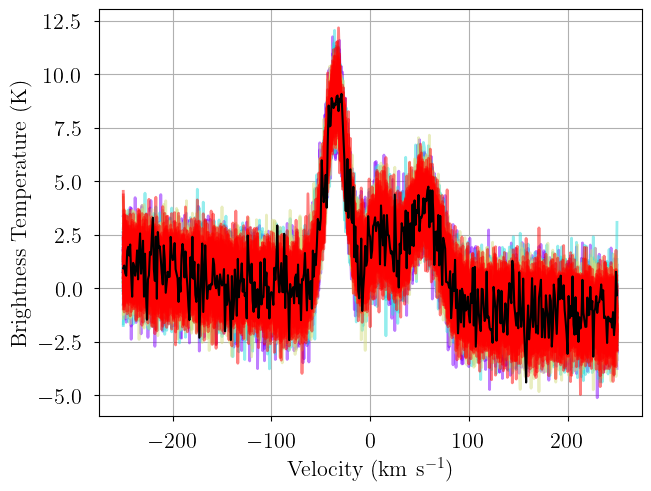

In [31]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

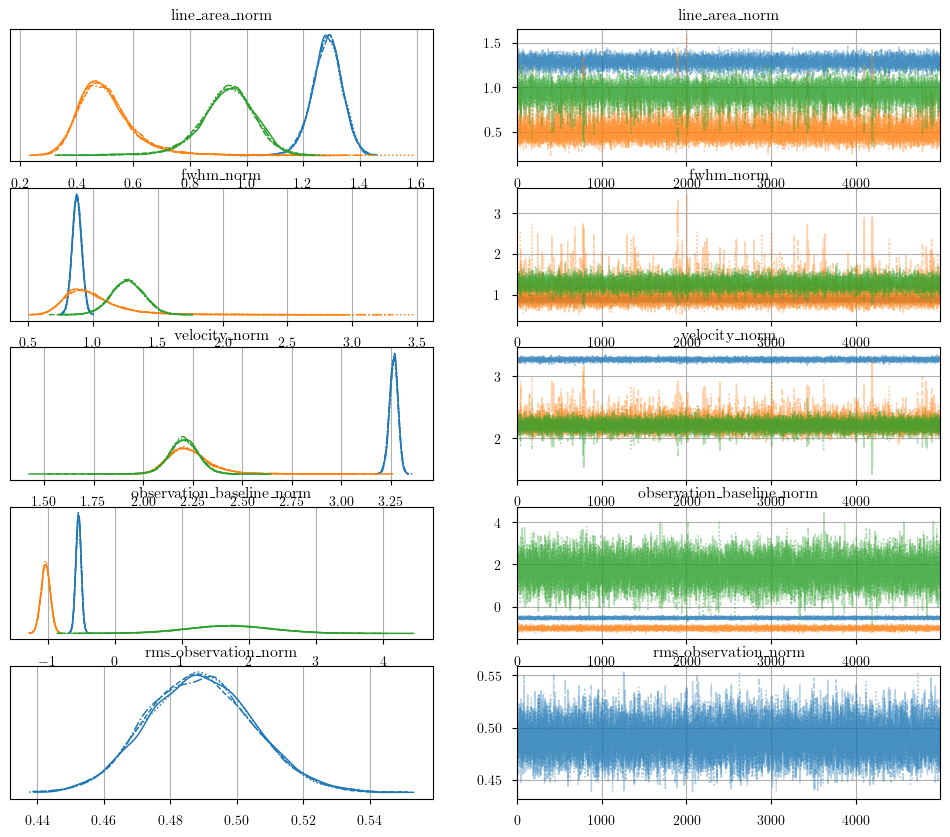

In [32]:
plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

In [33]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
line_area[0],256.660,10.587,236.765,276.244,0.131,0.093,7027.0,6941.0,1.0
line_area[1],101.402,21.597,67.490,139.761,0.367,0.284,5119.0,4307.0,1.0
line_area[2],186.062,20.142,148.363,222.307,0.315,0.223,5045.0,4295.0,1.0
fwhm[0],26.249,1.083,24.270,28.358,0.011,0.008,9130.0,9444.0,1.0
fwhm[1],30.128,7.471,19.469,43.082,0.130,0.101,5111.0,4076.0,1.0
fwhm[2],37.979,3.814,30.918,45.206,0.051,0.036,5608.0,5324.0,1.0
velocity[0],-34.684,0.432,-35.517,-33.884,0.004,0.003,10971.0,10074.0,1.0
velocity[1],10.092,2.260,6.327,14.108,0.035,0.028,6388.0,4796.0,1.0
velocity[2],54.160,1.700,50.973,57.400,0.023,0.017,5920.0,5375.0,1.0
amplitude[0],9.190,0.286,8.653,9.722,0.002,0.001,19442.0,13359.0,1.0


## `blackjax`

`blackjax` is another JAX-based NUTS sampler, similar to `numpyro`. It can also be run on the GPU.

In [34]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "blackjax",
)

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/pymc/sampling/jax.py:368: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(


In [35]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]
INFO:pymc.sampling.forward:Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

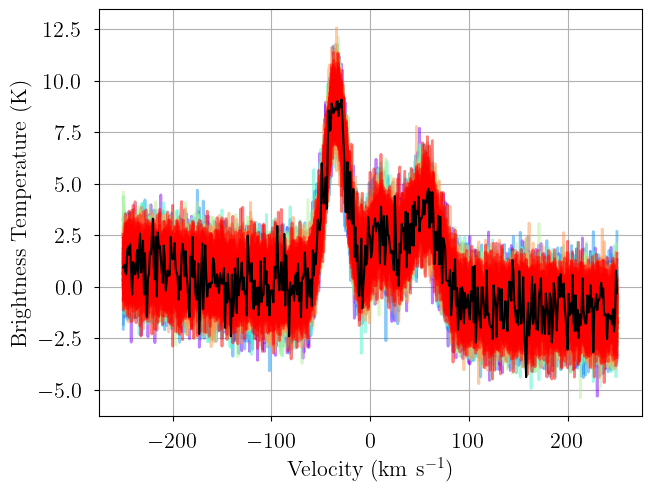

In [36]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

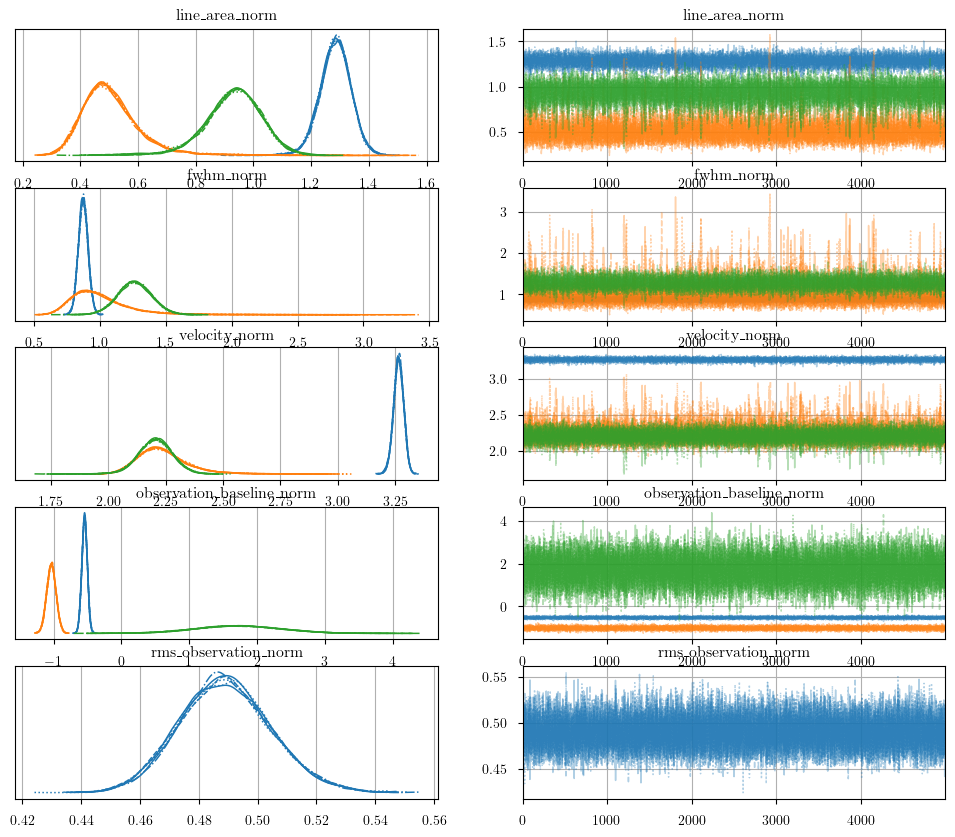

In [37]:
plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

In [38]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
line_area[0],256.615,10.717,236.340,276.172,0.105,0.074,11157.0,10113.0,1.0
line_area[1],101.770,21.527,67.858,140.003,0.278,0.209,7980.0,6854.0,1.0
line_area[2],185.778,20.059,148.143,221.495,0.248,0.176,7702.0,6329.0,1.0
fwhm[0],26.241,1.091,24.192,28.293,0.010,0.007,13124.0,14419.0,1.0
fwhm[1],30.236,7.469,19.544,43.209,0.101,0.075,7514.0,6686.0,1.0
fwhm[2],37.923,3.834,30.715,45.166,0.042,0.029,8446.0,8187.0,1.0
velocity[0],-34.687,0.436,-35.494,-33.859,0.003,0.002,15908.0,15381.0,1.0
velocity[1],10.107,2.234,6.216,14.126,0.027,0.020,9400.0,7112.0,1.0
velocity[2],54.198,1.705,51.064,57.511,0.018,0.013,9375.0,8490.0,1.0
amplitude[0],9.191,0.286,8.664,9.733,0.002,0.001,32302.0,20407.0,1.0
